In [1]:
import numpy as np
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from scipy.integrate import dblquad, tplquad, trapezoid


In [2]:
print(const.M_sun)
print(const.G)
print(const.R_jup)

  Name   = Solar mass
  Value  = 1.988409870698051e+30
  Uncertainty  = 4.468805426856864e+25
  Unit  = kg
  Reference = IAU 2015 Resolution B 3 + CODATA 2018
  Name   = Gravitational constant
  Value  = 6.6743e-11
  Uncertainty  = 1.5e-15
  Unit  = m3 / (kg s2)
  Reference = CODATA 2018
  Name   = Nominal Jupiter equatorial radius
  Value  = 71492000.0
  Uncertainty  = 0.0
  Unit  = m
  Reference = IAU 2015 Resolution B 3


In [12]:


def sigma_cap(v1Mag, v1primeMag, vBMag, v_esc, muB):
    """
    Capture cross-section σ_cap(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    v1_prime : float
        Incoming velocity in Body B frame.
    vB : float
        Orbital velocity of body B.
    vesc : float
        Escape velocity of body A or system.
    muB : float
        Reduced mass associated with body B (μ_B).

    Returns
    -------
    float
        σ_cap(v1)
    """
    numerator = np.pi * muB**2 * ((v1primeMag**2 - vBMag**2)**2 - v_esc**4)
    denominator = (v1Mag**2 - v_esc**2)**2 * v1primeMag**4
    return numerator / denominator

# def sigma_cap_dEps(v1, v1_prime, vB, v_esc, muB, kappa):
#     """
#     Differential capture cross-section dσ_cap/dε.

#     Parameters
#     ----------
#     v1 : float
#         Incoming velocity.
#     v1_prime : float
#         Incoming velocity in Body B frame.
#     vB : float
#         Orbital velocity of body B.
#     vesc : float
#         Escape velocity of body A or system.
#     muB : float
#         Reduced mass associated with body B (μ_B).
#     kappa : float
#         Energy dissipation parameter.

#     Returns
#     -------
#     float
#         dσ_cap/dε
#     """
#     sigma_cap_val = 16
#     return sigma_cap_val / kappa

def sigma_collision(R, b, bmin, rmin):
    """
    Collision cross-section σ_collision(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    muB : float
        Reduced mass associated with body B (μ_B).
    r_close : float
        Closest approach distance.

    Returns
    -------
    float
        σ_collision(v1)
    """
    sigma_int_1 = -(0.5*(-b + R + bmin) * (b + R - bmin) * (b - R + bmin) * (b + R + bmin))**0.5
    sigma_int_2 = R**2 * np.arccos((b**2 + R**2 - bmin**2) / (2*b*R))
    sigma_int_3 = rmin**2 * np.arccos((b**2 + bmin**2 - R**2) / (2*b*bmin))

    return sigma_int_1 + sigma_int_2 + sigma_int_3
    

def crossec_circle_R_b(v1Mag,  vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB):
    v1_prime_vec_xy = v1primeVec.copy()
    v1_prime_vec_xy[2] = 0.0
    v1_prime_mag_xy = np.linalg.norm(v1_prime_vec_xy, axis=0)  # shape (n_mu, n_lam)

    # Per-element dot product and cross product
    dot_vB_v1p = np.einsum('i... , i... -> ...', vBVec, v1primeVec)           # shape (n_mu, n_lam)
    cross_v1p_vB = np.cross(v1primeVec, vBVec, axis=0)                         # shape (3, n_mu, n_lam)

    v1prime_z = v1primeVec[2]                                                  # shape (n_mu, n_lam)
    v1prime_y = v1primeVec[1]                                                  # shape (n_mu, n_lam)
    cross_z = cross_v1p_vB[2]                                                  # shape (n_mu, n_lam)

    # Build g1..g5 as arrays
    g1 = 4*muB * dot_vB_v1p * (v1primeMag**6) * v1prime_z
    g2 = 4*(muB**3) * dot_vB_v1p * (v1primeMag**2) * v1prime_z
    g3 = 4*muB * (v1primeMag**7) * cross_z
    g4 = np.sign(v1prime_y) * (v1_prime_mag_xy**8) * v1_prime_mag_xy * (v1Mag**2 - vesc**2)
    g5 = 2 * np.sign(v1prime_y) * (muB**2) * (v1primeMag**4) * v1_prime_mag_xy * (v1primeMag**2 + vBMag**2 - vesc**2)

    # Avoid divisions by zero and negative expr with masks
    mask = (g1 != 0) & (g4 != 0)
    expr = np.zeros_like(g1)
    expr[mask] = g2[mask]/g1[mask] + (g1[mask]**2 + g3[mask]**2)/(4*g4[mask]**2) - g5[mask]/g4[mask]

    # Only keep positive expr
    pos = mask & (expr > 0)

    Rb = np.zeros_like(expr)
    b  = np.zeros_like(expr)

    Rb[pos] = np.sqrt(expr[pos])
    b[pos]  = -0.5*(g3[pos] + g1[pos]) / g4[pos]

    return Rb, b
    

def v_esc(muA, rAB):
    """
    Escape velocity v_esc.

    Parameters
    ----------
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        v_esc
    """

    return np.sqrt(2 * muA / rAB)

def r_close(epsilon, mA, mB, rAB):
    """
    Closest approach distance r_close.

    Parameters
    ----------
    epsilon : float
        Energy dissipation parameter.
    mA : float
        Mass of body A.
    mB : float
        Mass of body B.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        r_close
    """

    return rAB * (epsilon * mB / mA)**(1/3)

def r_min(muA, b, v1_prime):
    """
    Minimum approach distance b_min.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    b : float
        Impact parameter.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        r_min
    """

    e1_prime = np.sqrt(1 + (b**2 * v1_prime**4) / muA**2)
    a1_prime = -b / np.sqrt(e1_prime**2 - 1)
    r_min = (np.sqrt(muA**2 + b**2 * v1_prime**4) - muA) / (v1_prime**2)

    return a1_prime * (1-e1_prime)

def r_AB_vec(rAB, lambda_1):
    """
    Separation vector between bodies A and B r_AB.

    Parameters
    ----------
    rAB : float
        Separation between bodies A and B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    float
        r_AB
    """
    rABVec = np.array([ # broadcast over grid
        np.zeros_like(lambda_1),
        np.ones_like(lambda_1) * rAB,
        np.zeros_like(lambda_1)
    ])
    return rABVec

def b_min(muB, rB, v1_prime):
    """
    Minimum impact parameter b_min.

    Parameters
    ----------
    muB : float
        Reduced mass associated with body B (μ_B).
    rB : float
        Radius of body B.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        b_min
    """
    b_min = np.sqrt(2*muB*rB + (rB*v1_prime)**2) / v1_prime

    return b_min

def v_1_mag(v_inf, muA, muB, rAB, rClose):
    """
    Incoming velocity v1.

    Parameters
    ----------
    v_inf : float
        Velocity at infinity.
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.


    Returns
    -------
    float
        v1
    """

    term1 = v_inf**2 + (2 * muA / rAB)
    term2 = (2 * muB / rClose)
    return np.sqrt(term1 + term2)

def v_1_vec(v1Mag, lambda_1, beta_1):
    """
    Incoming velocity v1.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1
    """
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1Mag * np.array([
        np.sin(lambda_1) * np.cos(beta_1),
        np.cos(lambda_1) * np.cos(beta_1),
        -np.sin(beta_1),
    ])
    return v1_vec

def v_1_prime_mag(v1primeVec):
    """
    Magnitude of incoming velocity in Body B frame |v1'|.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        |v1'|
    """
    return np.linalg.norm(v1primeVec, axis=0)

def v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1):
    """
    Incoming velocity in Body B frame v1'.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1'
    """
    v1_prime_vec = v1Vec - vBVec
    return v1_prime_vec

def v_2_vec(v1primeVec,v1primeMag,vBVec, muB, b, phi):
    """
    Outgoing velocity v2.
    Parameters
    ----------
    v1primeVec : float
        Incoming velocity vector in Body B frame.
    v1primeMag : float
        Magnitude of incoming velocity in Body B frame.
    muB : float
        Reduced mass associated with body B (μ_B).
    vB : float
        Orbital velocity of body B.
    b : float
        Impact parameter. 
    Returns
    -------
    float
        v2
    """

    v1prime_vec = v1primeVec.copy()
    v1prime_x = v1prime_vec[0]
    v1prime_y = v1prime_vec[1]
    v1prime_z = v1prime_vec[2]
    v1prime_xy = v1prime_vec.copy()
    v1prime_xy[2] = 0.0
    v1primeMag_xy = np.linalg.norm(v1prime_xy, axis=0)

    q = np.sqrt(1 + v1prime_z**2/v1primeMag_xy**2)

    term1 = vBVec + (b**2 * v1primeMag**4 - muB**2)/(b**2 * v1primeMag**4 + muB**2) * v1primeVec
    term2 = (2 * np.sign(v1prime_y) * muB * v1primeMag * b)/(b**2 * v1primeMag**4 + muB**2) * np.array([
        q * (v1prime_x * v1prime_z * np.sin(phi) - v1primeMag * v1prime_y * np.cos(phi)),
        q * (v1prime_y * v1prime_z * np.sin(phi) + v1primeMag * v1prime_x * np.cos(phi)),
        -v1primeMag_xy**2 * np.sin(phi)
    ])
    return term1 + term2

def v_2_mag(v2Vec):
    """
    Magnitude of outgoing velocity |v2|.
    Parameters
    ----------
    v2Vec : float
        Outgoing velocity vector.
    Returns
    -------
    float
        |v2|
    """
    return np.linalg.norm(v2Vec, axis=0)

def v_B_vec(vBMag, lambda_1):
    """
    Orbital velocity vector of body B vB.
    Parameters
    ----------
    vBMag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    Returns
    -------
    float
        vB
    """
    vBVec = vBMag * np.array([np.sin(lambda_1), np.cos(lambda_1), np.zeros_like(lambda_1)])
    return vBVec


def chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec, vesc, sigma_cap,  rclose, rB, rmin, Rb, b, bmin):
    """
    Indicator function to check kinematical allowance χ.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ
    """
    condition0 = Rb > 0.0
    v_max = vesc + 2*vBMag               # scalar
    condition1 = v1Mag < v_max           # scalar, broadcasts
    condition2 = sigma_cap > 0           # array
    condition3 = Rb < rclose             # array
    # If you want to enforce rmin > rB and b > bmin, use these arrays; otherwise skip
    # condition4 = rmin > rB
    condition5 = b > bmin

    # Combine elementwise with &; convert to float (1.0/0.0)
    result_mask = condition0 & condition1 & condition2 & condition3 & condition5
    return result_mask.astype(float)
def chi_inE2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v2Mag, v1Mag, U, E2, rClose):
    """
    Indicator function to check kinematical allowance χ in E2.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ in E2
    """

    # Condition 1
    vesc = v2Mag
    Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    condition1 = Rb < rClose

    return 1.0 if condition1 else 0.0

def dsigma_directional_average(sigma_cap, chi, f_pdf, v1_mag):
    """
    Differential directional average cross-section dσ/dΩ.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    sigma_cap : float
        Capture cross-section.
    chi : float
        Kinematical allowance.

    Returns
    -------
    float
        dσ/dΩ
    """

    return (sigma_cap) * chi / (2*np.pi) * f_pdf / v1_mag

def U(muA, muB, rAB, rClose):
    """
    Potential energy U.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    rAB : float
        Separation between bodies A and B.
    rclose : float
        Closest approach distance.

    Returns
    -------
    float
        U parameter
    """
    U  = -(muA / rAB) - (muB / rClose)

    return U

def E2(v2Mag, U):
    """
    Final energy E2.

    Parameters
    ----------
    v2Mag : float
        Magnitude of the outgoing velocity vector.
    U : float
        Potential energy U.

    Returns
    -------
    float
        E2
    """
    return 0.5 * v2Mag**2 + U

def L2(rABVec, v2Vec):
    """
    Angular momentum L2.

    Parameters
    ----------
    rABVec : float
        Separation vector between bodies A and B.
    v2Vec : float
        Outgoing velocity vector.
    muA : float
        Reduced mass associated with body A (μ_A).

    Returns
    -------
    float
        L2
    """
    return np.linalg.norm(np.cross(rABVec, v2Vec, axis=0), axis=0)


def a_e(muA, E2, L2):
    """
    Semi-major axis a.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    E2 : float
        Final energy E2.
    L2 : float
        Angular momentum L2.

    Returns
    -------
    float
        a
    """
    a = - muA / (2*E2)
    e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))
    return a, e


def sigma_cap_in_E2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v1Mag, U, E2):
    """
    Differential directional average cross-section dσ/dΩ in E2.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    v_inf : float
        Velocity at infinity.
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    vB_mag : float
        Orbital velocity magnitude of body B.
    vesc : float
        Escape velocity of body A or system.
    sigcap : float
        Capture cross-section.
    rclose : float
        Closest approach distance.
    r_jupiter : float
        Radius of Jupiter.

    Returns
    -------
    float
        dσ/dΩ in E2
    """
    term1 = (16*np.pi * muB**2 * (U + E2)/(v1primeMag**4 * (v1Mag**2 - 2*(U-E2))**3)) 
    term2 = (vBMag**2 * (2*v1primeMag**2) + np.dot(vBVec, v1primeVec) + (v1primeMag**2 - 2*(U + E2) * np.dot(vBVec, v1primeVec)))
    sigma_cap_E2 = term1 * term2

    return sigma_cap_E2

In [4]:
G = const.G.value
m_Sun = const.M_sun.value
m_Jup =  const.M_jup.value  # Mass of Jupiter
m_Neptune = 5.15*10**-5 * const.M_sun.value  # Mass of Neptune
M_PBH = 1e-13 * const.M_sun.value
r_SJ = (5.2*u.au).to(u.m).value
r_SN = (30.07*u.au).to(u.m).value
v_Jup = 13.06 * 1e3  # km/s to m/s
v_Neptune = 5.45 * 1e3  # km/s to m/s
epsilon = 0.1
v_inf = 20.23 * 1e3  # km/s to m/s
r_jupiter = const.R_jup.to(u.m).value
r_neptune = 24622 * 1e3  # in meters
A_jupiter = np.pi * r_jupiter**2

In [21]:
rAB = r_SJ
rB = r_jupiter
mA = m_Sun
mB = m_Jup
muA = G * mA
muB = G * mB
vesc = v_esc(muA, rAB)
rclose = r_close(epsilon, mA, mB, rAB)
v1Mag = v_1_mag(v_inf, muA, muB, rAB, rclose)
v_max = np.sqrt((vesc + v_Jup)**2 - 2*muA/r_SJ - 2*muB/rclose)
vBMag = v_Jup
vdm = 220e3  # m/s
a_SJ = []
e_SJ = []
E2s = []
L2s = []
v2vecs = []
chis = []
phi = 0.0
i = []
n_lam = 500
n_mu = 500
n_phi = 100
# i = [] --- IGNORE ---
lam_grid = np.linspace(0.0, 2*np.pi, n_lam)
mu_grid = np.linspace(-1.0, 1.0, n_mu)
# phi = np.linspace(0.0, 2*np.pi, n_phi) 
v_inf_grid = np.linspace(1e3, v_max, 25)  # m/s --- IGNORE ---

# Precompute constants

# Build 2D mesh
Lam, Mu, v = np.meshgrid(lam_grid, mu_grid, v_inf_grid, indexing='xy')  # shape (n_mu, n_lam, n_phi)

# Evaluate integrand on the grid
Beta = np.arccos(Mu)
v1Vec = v_1_vec(v1Mag, Lam, Beta)
vBVec = v_B_vec(vBMag, Lam)
v1primeVec = v_1_prime_vec(v1Vec, vBVec, Lam, Beta)
v1primeMag = v_1_prime_mag(v1primeVec)
sigcap = sigma_cap(v1Mag, v1primeMag, vBMag, vesc, muB)
f_pdf = (np.sqrt(2/np.pi)) * (v**2 / (vdm**3)) * np.exp(- (v)**2/(2*vdm**2))
Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
bmin = b_min(muB, r_jupiter, v1primeMag)
rmin = r_min(muA, b, v1primeMag)

allow = chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec, vesc, sigcap, rclose, r_jupiter, rmin, Rb, b, bmin)
F = dsigma_directional_average(sigcap, allow, f_pdf, v1Mag)  # shape (n_mu, n_lam)

# Trapezoidal integration: first over mu (axis=0), then over lambda (axis=1)
I_mu = trapezoid(F, x=mu_grid, axis=0)         # shape (n_lam,)
I_lam = trapezoid(I_mu, x=lam_grid, axis=0)       # scalar
I_vinf = trapezoid(I_lam, x=v_inf_grid, axis=0)   # scalar

print("Directional average cross section (trapz):", I_lam)
print("In terms of Jupiter's area:", I_lam / A_jupiter)
print("Directional average cross section over v_inf (trapz):", I_vinf)
print("In terms of Jupiter's area over v_inf:", I_vinf / A_jupiter)

Directional average cross section (trapz): [  143.13388354   582.45756146  1317.95745156  2349.53920094
  3677.07047835  5300.38099539  7219.26253385  9433.46897904
 11942.71635931 14746.6828915  17845.00903258 21237.29753724
 24923.11352153 28901.98453259 33173.40062428 37736.81443889
 42591.64129479 47737.25928003 53173.0093519  58898.1954424
 64912.08456961 71213.90695494 77802.85614625 84678.08914672
 91838.72654969]
In terms of Jupiter's area: [8.91410384e-15 3.62743402e-14 8.20798632e-14 1.46324797e-13
 2.29000899e-13 3.30097566e-13 4.49601829e-13 5.87498361e-13
 7.43769477e-13 9.18395137e-13 1.11135295e-12 1.32261817e-12
 1.55216373e-12 1.79996018e-12 2.06597579e-12 2.35017645e-12
 2.65252576e-12 2.97298498e-12 3.31151307e-12 3.66806669e-12
 4.04260017e-12 4.43506559e-12 4.84541271e-12 5.27358904e-12
 5.71953981e-12]
Directional average cross section over v_inf (trapz): 780651315.1013336
In terms of Jupiter's area over v_inf: 4.861746716808733e-08


/tmp/ipykernel_12083/532034490.py:178: RuntimeWarning: invalid value encountered in divide
  a1_prime = -b / np.sqrt(e1_prime**2 - 1)


Directional average cross section (trapz): [  143.13388354  7219.26253385 24923.11352153 53173.0093519
 91838.72654969]
In terms of Jupiter's area: [8.91410384e-15 4.49601829e-13 1.55216373e-12 3.31151307e-12
 5.71953981e-12]
Directional average cross section over v_inf (trapz): 801457657.9117699
In terms of Jupiter's area over v_inf: 4.9913246306489274e-08

In [22]:
err = (abs( 4.858932869327462e-08) - abs(4.861746716808733e-08))/abs( 4.858932869327462e-08)
percent_err = err * 100
print("Error:", err)
print("Percent Error:", percent_err)

Error: -0.0005791081204338713
Percent Error: -0.057910812043387126


In [6]:
U_val = U(muA, muB, rAB, rclose)
rABVec = r_AB_vec(rAB, Lam)
print(rABVec.shape)

phi = np.linspace(0.0, 2*np.pi, 10)
a_vals = []
e_vals = []
for p in phi:
    phi_array = p * np.ones_like(v1primeMag)
    v2Vec = v_2_vec(v1primeVec, v1primeMag, vBVec, muB, b, phi_array)
    print(v2Vec.shape)
    v2Mag = v_2_mag(v2Vec)
    E2_val = E2(v2Mag, U_val)
    E2_cap_mask = E2_val < 0
    L2_val = L2(rABVec, v2Vec)
    a_val, e_val = a_e(muA, E2_val, L2_val)
    a_vals.append(a_val*E2_cap_mask)
    e_vals.append(e_val*E2_cap_mask)
    print("E2 min:", np.min(E2_val))
    print("E2 max:", np.max(E2_val))    
    print("E2 < 0 fraction:", np.sum(E2_val < 0) / E2_val.size)
    # plt.figure(figsize=(3,3))
    # ax = plt.gca()
    # plt.imshow(E2_val, extent=(0, 2*np.pi, -1, 1), origin='lower', aspect='auto')
    # plt.colorbar(label='E2 Value')


(3, 500, 500, 5)
(3, 500, 500, 5)


/tmp/ipykernel_12083/294679704.py:551: RuntimeWarning: invalid value encountered in sqrt
  e = np.sqrt(1 + (2*E2*L2**2)/(muA**2))


E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.014
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.018
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.022
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.02
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.016
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.014
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.012
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.012
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.012
(3, 500, 500, 5)
E2 min: -173178975.64240417
E2 max: 1264686275.642405
E2 < 0 fraction: 0.014


In [7]:

a_tot = np.concatenate(a_vals)
e_tot = np.concatenate(e_vals)
print("Overall a and e statistics:")
a_tot_positive = a_tot[a_tot > 0]*u.m.to(u.au)
e_tot_positive = e_tot[e_tot > 0]
print(f'a mean: {np.mean(a_tot_positive)}, std: {np.std(a_tot_positive)}')
print(f'a min: {np.min(a_tot_positive)}, a max: {np.max(a_tot_positive)}')
print(f'e mean: {np.mean(e_tot_positive)}, std: {np.std(e_tot_positive)}')
print(f'e min: {np.min(e_tot_positive)}, e max: {np.max(e_tot_positive)}')
for phi_val in range(len(phi)):
    a = (a_vals[phi_val]*u.m).to(u.au).value
    e = e_vals[phi_val]
    print(f'a and e for phi={phi[phi_val]:.2f}:')
    print(f'a mean: {np.mean(a)}, std: {np.std(a)}')
    print(f'a min: {np.min(a[a>0])}, a max: {np.max(a)}')
    print(f'e mean: {np.mean(e)}, std: {np.std(e)}')
    print(f'e min: {np.min(e[e>0])}, e max: {np.max(e)}')
    

Overall a and e statistics:
a mean: 9.360498755423, std: 24.00197304897504
a min: 2.561303599637425, a max: 207.30268802824344
e mean: 0.7410290297767267, std: 0.2305018826846802
e min: 0.011367228704956643, e max: 1.0
a and e for phi=0.00:
a mean: 0.08371547347846164, std: 0.909326095905644
a min: 2.561303599637425, a max: 17.30773836006098
e mean: nan, std: nan
e min: 0.01560650903215131, e max: nan
a and e for phi=0.70:
a mean: 0.1040303520423814, std: 1.0147986076686544
a min: 2.561303599637425, a max: 18.765946579168325
e mean: nan, std: nan
e min: 0.014185789446369071, e max: nan
a and e for phi=1.40:
a mean: 0.15189123968436752, std: 1.5911587294959681
a min: 2.561303599637425, a max: 31.872648714816535
e mean: nan, std: nan
e min: 0.015713560661447825, e max: nan
a and e for phi=2.09:
a mean: 0.11066419228671691, std: 1.0203946069435514
a min: 2.561303599637425, a max: 18.482548850293924
e mean: nan, std: nan
e min: 0.020125575115161415, e max: nan
a and e for phi=2.79:
a mean:

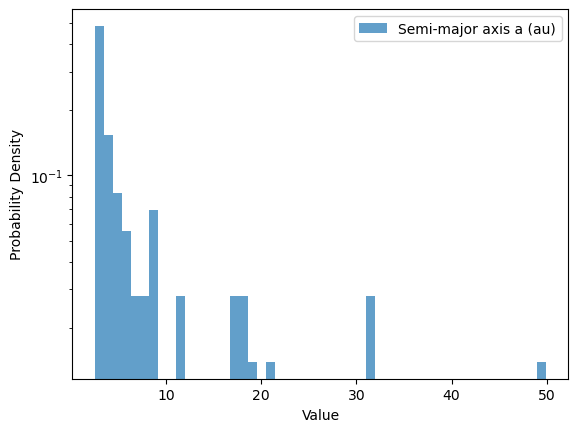

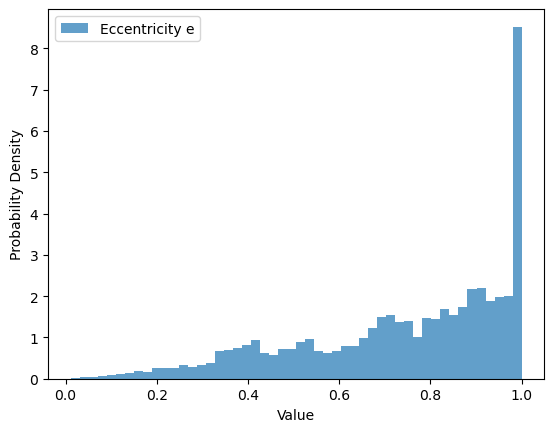

In [8]:
plt.hist(a_tot_positive[a_tot_positive < 120], density=True, bins=50, alpha=0.7, label='Semi-major axis a (au)')
plt.xlabel('Value')
plt.yscale('log')
plt.ylabel('Probability Density')
plt.legend()
plt.show()
plt.hist(e_tot_positive, density=True, bins=50, alpha=0.7, label='Eccentricity e')
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [9]:
# ...existing code...
Rb_scaled    = Rb / r_jupiter
b_scaled     = b  / r_jupiter
bmin_scaled  = bmin / r_jupiter
rclose_scaled = rclose / r_jupiter


# Centers from scaled b
b_x = b_scaled * np.sin(Lam) 
b_y = b_scaled * np.cos(Lam)

# Select nearest indices for lambda=0 and beta=pi/3


from matplotlib.patches import Circle

# Valid circles
valid = (Rb_scaled > 0.0)  & (sigcap > 0.0) & (Rb_scaled + b_scaled < rclose_scaled) & (b_x == 0)

# Downsample
step = 20
idx_mu, idx_lam = np.where(valid)
mask_ds = (idx_mu % step == 0) & (idx_lam % step == 0)
idx_mu_ds = idx_mu[mask_ds]
idx_lam_ds = idx_lam[mask_ds]

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect('equal', adjustable='box')
ax.set_title('Capture disks in impact-parameter space')
ax.set_xlabel('b_x / R_J')
ax.set_ylabel('b_y / R_J')

ax.add_patch(Circle((0, 0), rclose_scaled, edgecolor='gray', facecolor='none', linestyle='--', label='r_close'))
ax.add_patch(Circle((0, 0), 1, edgecolor='gray', facecolor='black', linestyle='--', label='r_close'))

for j_mu, j_lam in zip(idx_mu_ds, idx_lam_ds):
    cx = b_x[j_mu, j_lam]
    cy = b_y[j_mu, j_lam]
    R = Rb_scaled[j_mu, j_lam]
    ax.add_patch(Circle((cx, cy), R, edgecolor='C0', facecolor='none', alpha=0.6))

# # Highlight λ=0, β=π/3 in red (only if radius is positive)
# cx_sel = b_x[i_mu, i_lam]
# cy_sel = b_y[i_mu, i_lam]
# R_sel = Rb[i_mu, i_lam]
# if R_sel > 0:
#     ax.add_patch(Circle((cx_sel, cy_sel), R_sel, edgecolor='red', linewidth=2.0, facecolor='none', label='λ=0, β=π/3'))

# Limits
if idx_mu_ds.size > 0:
    bx_vals = b_x[idx_mu_ds, idx_lam_ds]
    by_vals = b_y[idx_mu_ds, idx_lam_ds]
    R_vals = Rb_scaled[idx_mu_ds, idx_lam_ds]
    rmax = rclose_scaled
    ax.set_xlim(-rmax, rmax)
    ax.set_ylim(-rmax, rmax)

ax.legend(loc='upper right')
plt.tight_layout()
plt.show()
# ...existing code...

ValueError: too many values to unpack (expected 2)

497.2913570590998


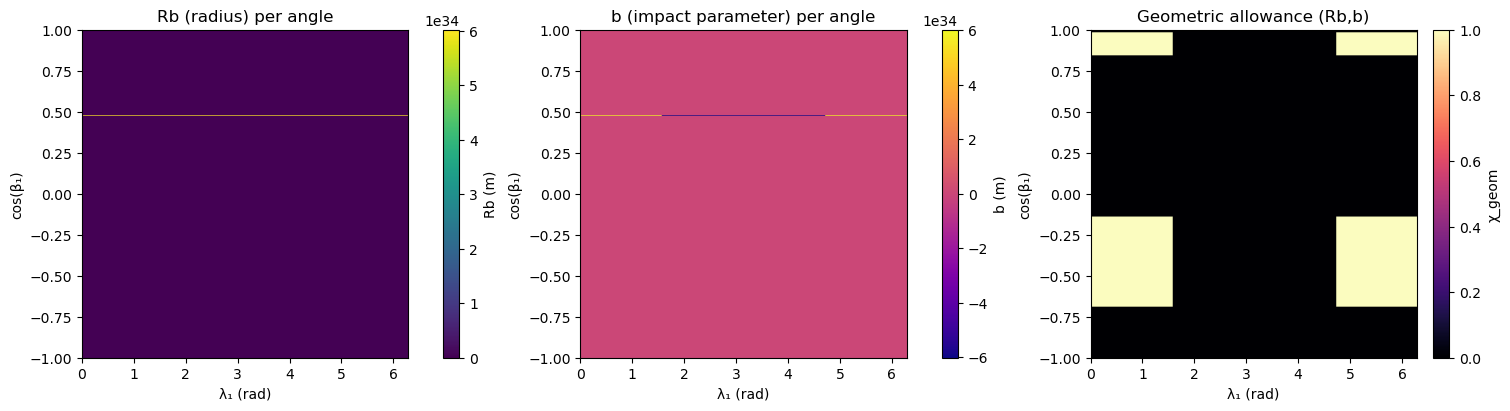

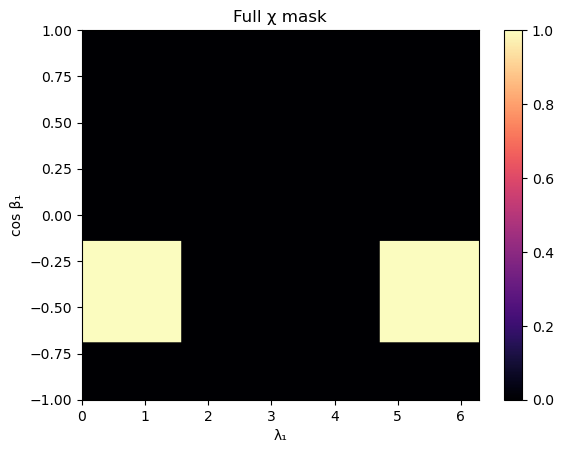

In [ ]:
# Visualize Rb and b over (λ, μ) and the allowance mask
fig, axs = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

im0 = axs[0].imshow(Rb, extent=(0, 2*np.pi, -1, 1), origin='lower', aspect='auto', cmap='viridis')
axs[0].set_title('Rb (radius) per angle')
axs[0].set_xlabel('λ₁ (rad)')
axs[0].set_ylabel('cos(β₁)')
cbar0 = plt.colorbar(im0, ax=axs[0])
cbar0.set_label('Rb (m)')

im1 = axs[1].imshow(b, extent=(0, 2*np.pi, -1, 1), origin='lower', aspect='auto', cmap='plasma')
axs[1].set_title('b (impact parameter) per angle')
axs[1].set_xlabel('λ₁ (rad)')
axs[1].set_ylabel('cos(β₁)')
cbar1 = plt.colorbar(im1, ax=axs[1])
cbar1.set_label('b (m)')

# Allowance using Rb and b cuts (already in allow). For a pure geometric mask:
geom_allow = ((Rb > 0.0) & (Rb < rclose) & (b > bmin)).astype(float)
im2 = axs[2].imshow(geom_allow, extent=(0, 2*np.pi, -1, 1), origin='lower', aspect='auto', cmap='magma')
axs[2].set_title('Geometric allowance (Rb,b)')
axs[2].set_xlabel('λ₁ (rad)')
axs[2].set_ylabel('cos(β₁)')
cbar2 = plt.colorbar(im2, ax=axs[2])
cbar2.set_label('χ_geom')

plt.show()
plt.figure()
plt.imshow(allow, extent=(0, 2*np.pi, -1, 1),
           origin='lower', aspect='auto', cmap='magma')
plt.title('Full χ mask')
plt.xlabel('λ₁')
plt.ylabel('cos β₁')
plt.colorbar()
plt.show()


In [ ]:
a_SJ = [(a*u.m).to(u.au).value for a in a_SJ]
print("Average a:", np.mean(a_SJ), 'min:', np.min(a_SJ), 'max:', np.max(a_SJ))
print("Average e:", np.mean(e_SJ), 'min:', np.min(e_SJ), 'max:', np.max(e_SJ))
print("Average E2:", np.mean(E2s), 'min:', np.min(E2s), 'max:', np.max(E2s))
print("Average L2:", np.mean(L2s), 'min:', np.min(L2s), 'max:', np.max(L2s))
print(len(a_SJ), len(e_SJ), len(E2s), len(L2s), i, len(chis), np.sum(chis))

/grad/a.saricaoglu/.conda/envs/compas/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/grad/a.saricaoglu/.conda/envs/compas/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

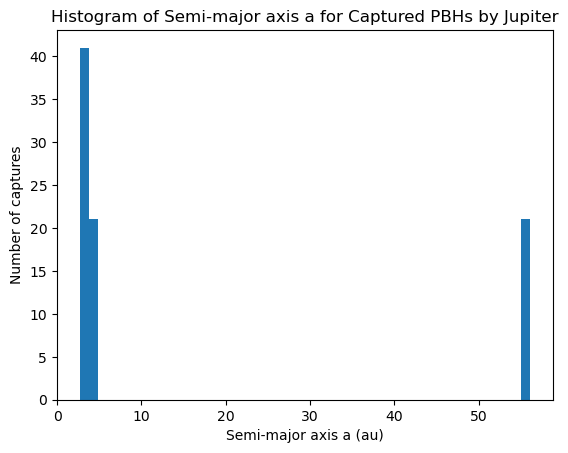

In [ ]:
plt.hist(a_SJ[:-1], bins=50)
plt.xlabel('Semi-major axis a (au)')
plt.ylabel('Number of captures')
plt.title('Histogram of Semi-major axis a for Captured PBHs by Jupiter')
plt.show()

In [ ]:
rAB = r_SN
rB = r_neptune
mA = m_Sun
mB = m_Neptune
muA = G * mA
muB = G * mB
vesc = v_esc(muA, rAB)
v_inf = 8.436 * 1e3  # km/s to m/s
rclose = r_close(epsilon, mA, mB, rAB)
v1Mag = v_1_mag(v_inf, muA, muB, rAB, rclose)
vBMag = v_Neptune
def integrand(cosbeta_1, lambda_1):
    beta_1 = np.arccos(cosbeta_1)
    v1Vec = v_1_vec(v1Mag, lambda_1, beta_1)
    vBVec = v_B_vec(vBMag, lambda_1)
    v1primeVec = v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1)
    v1primeMag = v_1_prime_mag(v1primeVec)
    sigcap = sigma_cap(v1Mag, v1primeMag, vBMag, vesc, muB)

    Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    if Rb <= 0.0:
        return 0.0

    bmin = b_min(muB, rB, v1primeMag)
    rmin = r_min(muA, b, v1primeMag)

    allow = chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec,
                vesc, sigcap, rclose, rB, rmin, Rb, b, bmin)

    return dsigma_directional_average(sigcap, allow)

e = 0.1
res, err = dblquad(
    integrand,
    0, 2*np.pi,
    lambda cosbeta_1: -1,
    lambda cosbeta_1: 1, 
    epsabs=1e-10,
    epsrel=1e-10,

)
print("Integrated directional average cross section:", res, " +/- ", err)
print(f'In terms of Jupiter\'s area: {((res)/A_jupiter)}')

/grad/a.saricaoglu/.conda/envs/compas/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Integrated directional average cross section: 1.2914443958545402e+16  +/-  6742670.5
In terms of Jupiter's area: 0.8042868089797345


In [ ]:

G = const.G.value
mA = const.M_sun.value
muA = G * mA
mB =  const.M_jup.value  # Mass of Jupiter
muB = G * mB
M_PBH = 1e-13 * const.M_sun.value
rAB = (5.2*u.au).to(u.m).value
vB_mag = 13.06 * 1e3  # km/s to m/s
kappa = 25
epsilon = 0.1
v_inf = 20.23 * 1e3  # km/s to m/s
r_jupiter = const.R_jup.to(u.m).value
A_jupiter = np.pi * r_jupiter**2

def sigma_cap(v1Mag, v1primeMag, vBMag, v_esc, muB):
    """
    Capture cross-section σ_cap(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    v1_prime : float
        Incoming velocity in Body B frame.
    vB : float
        Orbital velocity of body B.
    vesc : float
        Escape velocity of body A or system.
    muB : float
        Reduced mass associated with body B (μ_B).

    Returns
    -------
    float
        σ_cap(v1)
    """
    numerator = np.pi * muB**2 * ((v1primeMag**2 - vBMag**2)**2 - v_esc**4)
    denominator = (v1Mag**2 - v_esc**2)**2 * v1primeMag**4
    return numerator / denominator

# def sigma_cap_dEps(v1, v1_prime, vB, v_esc, muB, kappa):
#     """
#     Differential capture cross-section dσ_cap/dε.

#     Parameters
#     ----------
#     v1 : float
#         Incoming velocity.
#     v1_prime : float
#         Incoming velocity in Body B frame.
#     vB : float
#         Orbital velocity of body B.
#     vesc : float
#         Escape velocity of body A or system.
#     muB : float
#         Reduced mass associated with body B (μ_B).
#     kappa : float
#         Energy dissipation parameter.

#     Returns
#     -------
#     float
#         dσ_cap/dε
#     """
#     sigma_cap_val = 16
#     return sigma_cap_val / kappa

def sigma_collision(R, b, bmin, rmin):
    """
    Collision cross-section σ_collision(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    muB : float
        Reduced mass associated with body B (μ_B).
    r_close : float
        Closest approach distance.

    Returns
    -------
    float
        σ_collision(v1)
    """
    sigma_int_1 = -(0.5*(-b + R + bmin) * (b + R - bmin) * (b - R + bmin) * (b + R + bmin))**0.5
    sigma_int_2 = R**2 * np.arccos((b**2 + R**2 - bmin**2) / (2*b*R))
    sigma_int_3 = rmin**2 * np.arccos((b**2 + bmin**2 - R**2) / (2*b*bmin))

    return sigma_int_1 + sigma_int_2 + sigma_int_3
    

def crossec_circle_R_b(v1Mag,  vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB):
    """
    Cross-section of a circle with radius R center b (impact parameter).

    Parameters
    ----------
    R : float
        Radius of the circle.
    b : float
        Center of the circle.
        
    Returns
    -------
    float
        cross-section radius R_b
    float
        impact parameter b
    """
    v1_prime_vec_xy = v1primeVec.copy()
    v1_prime_vec_xy[2] = 0.0
    v1_prime_mag_xy = np.linalg.norm(v1_prime_vec_xy)
    g1 = 4*muB*(np.dot(vBVec, v1primeVec))*(v1primeMag**6)*v1primeVec[2]
    g2 = 4*(muB**3)*(np.dot(vBVec, v1primeVec))*(v1primeMag**2)*v1primeVec[2]
    g3 = 4*muB*(v1primeMag**7)*(np.cross(v1primeVec, vBVec))[2]
    g4 = np.sign(v1primeVec[1])*(v1_prime_mag_xy**8)*v1_prime_mag_xy*(v1Mag**2 - vesc**2)
    g5 = 2 * np.sign(v1primeVec[1]) * (muB**2) * (v1primeMag**4) * v1_prime_mag_xy * (v1primeMag**2 + vBMag**2 - vesc**2)
    # compute g1..g5 first
    if g1 == 0 or g4 == 0:
        return 0.0

    expr = g2/g1 + (g1**2 + g3**2)/(4*g4**2) - g5/g4
    if expr <= 0:
        return 0.0, 0.0
    
    R = np.sqrt(g2/g1 + (g1**2 + g3**2)/(4*g4**2) - g5/g4)

    b = -1/(2*g4) * (g3 + g1)

    return R, b
    

def v_esc(muA, rAB):
    """
    Escape velocity v_esc.

    Parameters
    ----------
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        v_esc
    """

    return np.sqrt(2 * muA / rAB)

def r_close(epsilon, mA, mB, rAB):
    """
    Closest approach distance r_close.

    Parameters
    ----------
    epsilon : float
        Energy dissipation parameter.
    mA : float
        Mass of body A.
    mB : float
        Mass of body B.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        r_close
    """

    return rAB * (epsilon * mB / mA)**(1/3)

def r_min(muA, b, v1_prime):
    """
    Minimum approach distance b_min.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    b : float
        Impact parameter.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        r_min
    """

    e1_prime = np.sqrt(1 + (b**2 * v1_prime**4) / muA**2)
    a1_prime = -b / np.sqrt(e1_prime**2 - 1)
    r_min = (np.sqrt(muA**2 + b**2 * v1_prime**4) - muA) / (v1_prime**2)

    return a1_prime * (1-e1_prime)

def b_min(muB, rB, v1_prime):
    """
    Minimum impact parameter b_min.

    Parameters
    ----------
    muB : float
        Reduced mass associated with body B (μ_B).
    rB : float
        Radius of body B.
    v1_prime : float
        Incoming velocity in Body B frame.

    Returns
    -------
    float
        b_min
    """
    b_min = np.sqrt(2*muB*rB + (rB*v1_prime)**2) / v1_prime

    return b_min

def v_1_mag(v_inf, muA, muB, rAB, rClose):
    """
    Incoming velocity v1.

    Parameters
    ----------
    v_inf : float
        Velocity at infinity.
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.


    Returns
    -------
    float
        v1
    """

    term1 = v_inf**2 + (2 * muA / rAB)
    term2 = (2 * muB / rClose)
    return np.sqrt(term1 + term2)

def v_1_vec(v1Mag, lambda_1, beta_1):
    """
    Incoming velocity v1.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1
    """
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1Mag * np.array([
        np.sin(lambda_1) * np.cos(beta_1),
        np.cos(lambda_1) * np.cos(beta_1),
        -np.sin(beta_1),
    ])
    return v1_vec

def v_1_prime_mag(v1primeVec):
    """
    Magnitude of incoming velocity in Body B frame |v1'|.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        |v1'|
    """
    return np.linalg.norm(v1primeVec)

def v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1):
    """
    Incoming velocity in Body B frame v1'.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1'
    """
    v1_prime_vec = v1Vec - vBVec
    return v1_prime_vec

def v_2_vec(v1primeVec,v1primeMag,vBVec, muB, b, phi):
    """
    Outgoing velocity v2.
    Parameters
    ----------
    v1primeVec : float
        Incoming velocity vector in Body B frame.
    v1primeMag : float
        Magnitude of incoming velocity in Body B frame.
    muB : float
        Reduced mass associated with body B (μ_B).
    vB : float
        Orbital velocity of body B.
    b : float
        Impact parameter. 
    Returns
    -------
    float
        v2
    """

    v1prime_vec = v1primeVec.copy()
    v1prime_x = v1prime_vec[0]
    v1prime_y = v1prime_vec[1]
    v1prime_z = v1prime_vec[2]
    v1prime_xy = v1prime_vec.copy()
    v1prime_xy[2] = 0.0
    v1primeMag_xy = np.linalg.norm(v1prime_xy, axis=0)

    q = np.sqrt(1 + v1prime_z**2/v1prime_xy**2)

    term1 = vBVec + (b**2 * v1primeMag**4 - muB**2)/(b**2 * v1primeMag**4 + muB**2) * v1primeVec
    term2 = (2 * np.sign(v1prime_y) * muB * v1primeMag * b)/(b**2 * v1primeMag**4 + muB**2) * np.array([
        q * (v1prime_x * v1prime_z * np.sin(phi) - v1primeMag * v1prime_y * np.cos(phi)),
        q * (v1prime_y * v1prime_z * np.sin(phi) + v1primeMag * v1prime_x * np.cos(phi)),
        -v1primeMag_xy**2 * np.sin(phi)
    ])
    return term1 + term2

def v_2_mag(v2Vec):
    """
    Magnitude of outgoing velocity |v2|.
    Parameters
    ----------
    v2Vec : float
        Outgoing velocity vector.
    Returns
    -------
    float
        |v2|
    """
    return np.linalg.norm(v2Vec, axis=0)

def v_B_vec(vBMag, lambda_1):
    """
    Orbital velocity vector of body B vB.
    Parameters
    ----------
    vBMag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    Returns
    -------
    float
        vB
    """
    vBVec = vBMag * np.array([np.sin(lambda_1), np.cos(lambda_1), 0])
    return vBVec


def chi(muB, v1Mag, vBMag, v1primeMag, vBVec, v1primeVec, vesc, sigma_cap,  rclose, rB, rmin, Rb, b, bmin):
    """
    Indicator function to check kinematical allowance χ.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ
    """
    condition0 = Rb > 0.0
 
    # Condition 1
    v_max = vesc + 2*vBMag
    condition1 = v1Mag < v_max

    # Condition 2
    condition2 = sigma_cap > 0


    # Condition 3 (not needed as sigma_cap already incorporates this

    condition3 = Rb < rclose

    # Condition 4 r_min should be larger than rB
    condition4 = rmin > rB

    # Condition 5 b should be larger than b_min
    condition5 = b > bmin

    
    # print(f'Conditions: {condition1}, {condition2}, {condition3}, {condition4}, {condition5}')
    result = 1.0 if (condition0 and condition1 and condition2 and condition3 and condition4 and condition5) else 0.0

    return result

def chi_inE2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v2Mag, v1Mag, U, E2, rClose):
    """
    Indicator function to check kinematical allowance χ in E2.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ in E2
    """

    # Condition 1
    vesc = v2Mag
    R, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    condition1 = R < rClose

    return 1.0 if condition1 else 0.0

def dsigma_directional_average(sigma_cap, chi):
    """
    Differential directional average cross-section dσ/dΩ.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    sigma_cap : float
        Capture cross-section.
    chi : float
        Kinematical allowance.

    Returns
    -------
    float
        dσ/dΩ
    """

    return (sigma_cap) * chi / (2*np.pi)

def U(muA, muB, rAB, rClose):
    """
    Potential energy U.

    Parameters
    ----------
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    rAB : float
        Separation between bodies A and B.
    rclose : float
        Closest approach distance.

    Returns
    -------
    float
        U parameter
    """
    U  = -(muA / rAB) - (muB / rClose)

    return U

def E2(v2Mag, U):
    """
    Final energy E2.

    Parameters
    ----------
    v2Mag : float
        Magnitude of the outgoing velocity vector.
    U : float
        Potential energy U.

    Returns
    -------
    float
        E2
    """
    return 0.5 * v2Mag**2 + U

def sigma_cap_in_E2(muB, vBMag, vBVec, v1primeMag, v1primeVec, v1Mag, U, E2):
    """
    Differential directional average cross-section dσ/dΩ in E2.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    v_inf : float
        Velocity at infinity.
    muA : float
        Reduced mass associated with body A (μ_A).
    muB : float
        Reduced mass associated with body B (μ_B).
    vB_mag : float
        Orbital velocity magnitude of body B.
    vesc : float
        Escape velocity of body A or system.
    sigcap : float
        Capture cross-section.
    rclose : float
        Closest approach distance.
    r_jupiter : float
        Radius of Jupiter.

    Returns
    -------
    float
        dσ/dΩ in E2
    """
    term1 = (16*np.pi * muB**2 * (U + E2)/(v1primeMag**4 * (v1Mag**2 - 2*(U-E2))**3)) 
    term2 = (vBMag**2 * (2*v1primeMag**2) + np.dot(vBVec, v1primeVec) + (v1primeMag**2 - 2*(U + E2) * np.dot(vBVec, v1primeVec)))
    sigma_cap_E2 = term1 * term2

    return sigma_cap_E2

vesc = v_esc(muA, rAB)
rclose = r_close(epsilon, mA, mB, rAB)
v1Mag = v_1_mag(v_inf, muA, muB, rAB, rclose)
vBMag = vB_mag
def integrand(cosbeta_1, lambda_1):  # func(y, x): y = cosbeta_1, x = lambda_1
    beta_1 = np.arccos(cosbeta_1)
    v1Vec = v_1_vec(v1Mag, lambda_1, beta_1)
    vBVec = v_B_vec(vBMag, lambda_1)
    v1primeVec = v_1_prime_vec(v1Vec, vBVec, lambda_1, beta_1)
    v1primeMag = v_1_prime_mag(v1primeVec)
    sigcap = sigma_cap(v1Mag, v1primeMag, vBMag, vesc, muB)
    Rb, b = crossec_circle_R_b(v1Mag, vBMag, vBVec, v1primeMag, v1primeVec, vesc, muB)
    bmin = b_min(muB, r_jupiter, v1primeMag)
    rmin = r_min(muA, b, v1primeMag)
    # if rmin > r_jupiter:
    #     print(f'b-bmin: {b - bmin}, rmin - rjupiter: {rmin - r_jupiter}')
    # sigcol = sigma_collision(R, b, bmin, rmin)
    allow = chi(muB,v1Mag, vBMag, v1primeMag, vBVec, v1primeVec, vesc, sigcap, rclose,r_jupiter, rmin, Rb, b, bmin)
    # print(allow)
    return dsigma_directional_average(sigcap, allow)

e = 0.1
res, err = dblquad(
    integrand,
    0, 2*np.pi,
    lambda cosbeta_1: -1,
    lambda cosbeta_1: 1, 

)
print("Integrated directional average cross section:", res, " +/- ", err)
print(f'In terms of Jupiter\'s area: {((res)/A_jupiter)}')

/tmp/ipykernel_512764/1486035947.py:196: RuntimeWarning: invalid value encountered in scalar divide
  a1_prime = -b / np.sqrt(e1_prime**2 - 1)
/grad/a.saricaoglu/.conda/envs/compas/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Integrated directional average cross section: 2.1113655586585216e+16  +/-  637576011.6522028
In terms of Jupiter's area: 1.3149179888922173


without chi:
14.97410460456744 for 0, 2pi for lambda & 0, pi for beta
7.4870481200022825 for 0, pi for lambda & 0, pi for beta
with chi:
14.999128490217245 for 0, 2pi for lambda & 0, pi for beta
7.499568974815175 for 0, pi for lambda & 0, pi for beta
with chi & b check:
11.254511033661727 for 0, 2pi for lambda & 0, pi for beta
5.62726654507256 for 0, pi for lambda & 0, pi for beta
with chi & bmin check:
9.597438931190169 for 0, 2pi for lambda & 0, pi for beta
4.798699093001559 for 0, pi for lambda & 0, pi for beta

In [ ]:

G = const.G.value
mA = const.M_sun.value
muA = G * mA
mB =  const.M_jup.value  # Mass of Jupiter
muB = G * mB
M_PBH = 1e-13 * const.M_sun.value
rAB = (5.2*u.au).to(u.m).value
vB_mag = 13.06 * 1e3  # km/s to m/s
kappa = 25
epsilon = 0.1
v_inf = 20.23 * 1e3  # km/s to m/s
r_jupiter = const.R_jup.to(u.m).value
A_jupiter = np.pi * r_jupiter**2

def sigma_cap(v1, v1_prime, vB, v_esc, muB):
    """
    Capture cross-section σ_cap(v1).

    Parameters
    ----------
    v1 : float
        Incoming velocity.
    v1_prime : float
        Incoming velocity in Body B frame.
    vB : float
        Orbital velocity of body B.
    vesc : float
        Escape velocity of body A or system.
    muB : float
        Reduced mass associated with body B (μ_B).

    Returns
    -------
    float
        σ_cap(v1)
    """
    numerator = np.pi * muB**2 * ((v1_prime**2 - vB**2)**2 - v_esc**4)
    denominator = (v1**2 - v_esc**2)**2 * v1_prime**4
    return numerator / denominator

def v_esc(muA, rAB):
    """
    Escape velocity v_esc.

    Parameters
    ----------
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        v_esc
    """

    return np.sqrt(2 * muA / rAB)

def r_close(epsilon, mA, mB, rAB):
    """
    Closest approach distance r_close.

    Parameters
    ----------
    epsilon : float
        Energy dissipation parameter.
    mA : float
        Mass of body A.
    mB : float
        Mass of body B.
    rAB : float
        Separation between bodies A and B.

    Returns
    -------
    float
        r_close
    """

    return rAB * (epsilon * mB / mA)**(1/3)

def v_1(v_inf, muA, muB, rAB, r_close):
    """
    Incoming velocity v1.

    Parameters
    ----------
    v_inf : float
        Velocity at infinity.
    mA : float
        Mass of body A.
    rAB : float
        Separation between bodies A and B.


    Returns
    -------
    float
        v1
    """

    term1 = v_inf**2 + (2 * muA / rAB)
    term2 = (2 * muB / r_close)
    return np.sqrt(term1 + term2)

def v_1_prime(v1_mag, vB_mag, lambda_1, beta_1):
    """
    Incoming velocity in Body B frame v1'.
    Parameters
    ----------
    v1_mag : float
        Incoming velocity magnitude.
    vB_mag : float
        Orbital velocity magnitude of body B.
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter angle. 
    Returns
    -------
    float
        v1'
    """
    # B moves along +y
    vB_vec = np.array([0.0, vB_mag, 0.0])
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1_mag * np.array([
        np.cos(lambda_1) * np.cos(beta_1),
        np.sin(lambda_1) * np.cos(beta_1),
        np.sin(beta_1),
    ])
    v1_prime_vec = v1_vec - vB_vec
    return np.linalg.norm(v1_prime_vec)

def chi(muB,v1_mag, vB_mag, vesc, sigma_cap, lambda_1, beta_1, rclose):
    """
    Indicator function to check kinematical allowance χ.

    Parameters
    ----------
    v_1 : float
        Incoming velocity.
    vB : float
        Orbital velocity of body B.
    lambda_1 : float
        Scattering angle.

    Returns
    -------
    boolean
        χ
    """

    # Condition 1
    v_max = vesc + 2*vB_mag
    condition1 = v1_mag < v_max

    # Condition 2
    condition2 = sigma_cap > 0


    # Condition 3 (not needed as sigma_cap already incorporates this)

    # B moves along +y
    vB_vec = np.array([0.0, vB_mag, 0.0])
    # v1 direction set by (β1, λ1) as in Lehmann fig. 2
    v1_vec = v1_mag * np.array([
        np.cos(lambda_1) * np.cos(beta_1),
        np.sin(lambda_1) * np.cos(beta_1),
        np.sin(beta_1),
    ])

    v1_prime_vec = v1_vec - vB_vec
    v1_prime_mag = np.linalg.norm(v1_prime_vec)
    v1_prime_vec_xy = v1_prime_vec.copy()
    v1_prime_vec_xy[2] = 0.0
    v1_prime_mag_xy = np.linalg.norm(v1_prime_vec_xy)
    g1 = 4*muB*(np.dot(vB_vec, v1_prime_vec))*(v1_prime_mag**6)*v1_prime_vec[2]
    g2 = 4*(muB**3)*(np.dot(vB_vec, v1_prime_vec))*(v1_prime_mag**2)*v1_prime_vec[2]
    g3 = 4*muB*(v1_prime_mag**7)*(np.cross(v1_prime_vec, vB_vec))[2]
    g4 = np.sign(v1_prime_vec[1])*(v1_prime_mag**8)*v1_prime_mag_xy*(v1_mag**2 - vesc**2)
    g5 = 2 * np.sign(v1_prime_vec[1]) * (muB**2) * (v1_prime_mag**4) * v1_prime_mag_xy * (v1_mag**2 + vB_mag**2 - vesc**2)
    R = np.sqrt(g2/g1 + (g1**2 + g3**2)/(4*g4**2) - g5/g4)

    condition3 = R < rclose

    result = 1.0 if (condition1 and condition2 and condition3) else 0.0

    return result

def dsigma(lambda_1, cosbeta_1, sigma_cap, chi):
    """
    Differential cross-section dσ/dΩ.

    Parameters
    ----------
    lambda_1 : float
        Scattering angle.
    beta_1 : float
        Impact parameter.
    sigma_cap : float
        Capture cross-section.
    chi : float
        Kinematical allowance.

    Returns
    -------
    float
        dσ/dΩ
    """

    return sigma_cap * chi / (2*np.pi)
vesc = v_esc(muA, rAB)
rclose = r_close(epsilon, mA, mB, rAB)
v1_mag = v_1(v_inf, muA, muB, rAB, rclose)

def integrand(cosbeta_1, lambda_1):  # func(y, x): y = cosbeta_1, x = lambda_1
    beta_1 = np.arccos(cosbeta_1)
    v1p = v_1_prime(v1_mag, vB_mag, lambda_1, beta_1)
    sigcap = sigma_cap(v1_mag, v1p, vB_mag, vesc, muB)
    allow = chi(muB,v1_mag, vB_mag, vesc, sigcap, lambda_1, beta_1, rclose)
    return dsigma(lambda_1, cosbeta_1, sigcap, allow)

e = 0.1
res, err = dblquad(
    integrand,
    0, 2*np.pi,
    lambda lam: -1,
    lambda lam: 1
)
print("Integrated cross section:", res, " +/- ", err)